In [1]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import scipy.stats as stats
from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')

In /net/Jessica.Luo/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /net/Jessica.Luo/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /net/Jessica.Luo/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /net/Jessica.Luo/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /net/Jessica.Luo/miniconda3/lib/pytho

In [2]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Generate Paths

In [3]:
expt = 'historical'
#expt = 'piControl'

In [4]:
if expt=='historical':
    file_path = '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_historical_D1/gfdl.ncrc4-intel16-prod-openmp/pp'
    years = ['1995-1999', '2000-2004', '2005-2009', '2010-2014']
    yearmons = ['199501-199912', '200001-200412', '200501-200912', '201001-201412']
if expt=='piControl':
    file_path = '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/pp'
    years = ['0481-0485', '0486-0490', '0491-0495', '0496-0500']
    yearmons = ['048101-048512', '048601-049012', '049101-049512', '049601-050012']

diagType1 = 'ocean_cobalt_omip_tracers_year_z'
diagType2 = 'ocean_cobalt_omip_tracers_month_z'

In [5]:
# using python's list comprehension and path/string join method to put together the appropriate paths
dot = '.'
no3_var = 'no3'
no3_file_prefix = os.path.join(file_path, diagType1, 'ts', 'annual', '5yr/')
no3_files = [dot.join([no3_file_prefix + diagType1, yy, no3_var, 'nc']) for yy in years]
print(no3_files)

o2_var = 'o2'
o2_file_prefix = os.path.join(file_path, diagType1, 'ts', 'annual', '5yr/')
o2_files = [dot.join([o2_file_prefix + diagType1, yy, o2_var, 'nc']) for yy in years]
print(o2_files)

po4_var = 'po4'
po4_file_prefix = os.path.join(file_path, diagType1, 'ts', 'annual', '5yr/')
po4_files = [dot.join([po4_file_prefix + diagType1, yy, po4_var, 'nc']) for yy in years]
print(po4_files)

dfe_var = 'dfe'
dfe_file_prefix = os.path.join(file_path, diagType2, 'ts', 'monthly', '5yr/')
dfe_files = [dot.join([dfe_file_prefix + diagType2, ym, dfe_var, 'nc']) for ym in yearmons]
print(dfe_files)

['/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_historical_D1/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_cobalt_omip_tracers_year_z/ts/annual/5yr/ocean_cobalt_omip_tracers_year_z.1995-1999.no3.nc', '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_historical_D1/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_cobalt_omip_tracers_year_z/ts/annual/5yr/ocean_cobalt_omip_tracers_year_z.2000-2004.no3.nc', '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_historical_D1/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_cobalt_omip_tracers_year_z/ts/annual/5yr/ocean_cobalt_omip_tracers_year_z.2005-2009.no3.nc', '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_historical_D1/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_cobalt_omip_tracers_year_z/ts/annual/5yr/ocean_cobalt_omip_tracers_year_z.2010-2014.no3.nc']
['/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_historical_D1/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_cobalt_omip_tracers_year_z/ts/annual/5yr/ocean_cobalt_omip_tracers_year_z.1995-1999.o2.nc', '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_historical_D1/gfdl.ncrc4

In [6]:
grid_file = file_path + '/ocean_annual/ocean_annual.static.nc'
grid = xr.open_dataset(grid_file)

# Read in Data

### Models

In [7]:
# Get values at 500 m only; convert to mmol m-3; make 20-yr mean out of annual data

#no3
ds_no3 = xr.open_mfdataset(no3_files, combine='by_coords')
ds_no3 = ds_no3.sel(z_l=500.).mean(dim='time')
ds_no3['no3'].values = ds_no3['no3'].values * 1e3 # unit conversion to mmol m-3
ds_no3.no3.attrs['units'] = 'mmol m-3'

#o2
ds_o2 = xr.open_mfdataset(o2_files, combine='by_coords')
ds_o2 = ds_o2.sel(z_l=500.).mean(dim='time')
ds_o2['o2'].values = ds_o2['o2'].values * 1e3 # unit conversion to mmol m-3
ds_o2.o2.attrs['units'] = 'mmol m-3'

#po4
ds_po4 = xr.open_mfdataset(po4_files, combine='by_coords')
ds_po4 = ds_po4.sel(z_l=500.).mean(dim='time')
ds_po4['po4'].values = ds_po4['po4'].values * 1e3 # unit conversion to mmol m-3
ds_po4.po4.attrs['units'] = 'mmol m-3'


In [8]:
#dfe, use monthly data because sampling in observations is highly skewed toward spr/summer/fall
ds_dfe = xr.open_mfdataset(dfe_files, combine='by_coords')
ds_dfe = ds_dfe.sel(z_l=500.)

# unit conversion to micromol m-3
ds_dfe['dfe'].values = ds_dfe['dfe'].values * 1e6
ds_dfe.dfe.attrs['units'] = 'micromol m-3'

#create climatology
ds_dfe_clim=ds_dfe.groupby('time.month').mean(dim='time')

### Observations

In [9]:
# Nitrate
no3_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/nitrate_woa18_esm4grid.nc'
no3_obs = xr.open_dataset(no3_obs_file)
no3_obs = no3_obs.sel(z_l=500.)

# Oxygen, units of µmol/kg
o2_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/O2_woa18_esm4grid.nc'
o2_obs = xr.open_dataset(o2_obs_file)
o2_obs = o2_obs.sel(z_l=500.)

# Phosphate
po4_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/phosphate_woa18_esm4grid.nc'
po4_obs = xr.open_dataset(po4_obs_file)
po4_obs = po4_obs.sel(z_l=500.)

# Iron
dfe_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/fed_obs_500m.nc'
dfe_obs = xr.open_dataset(dfe_obs_file)
dfe_obs_ann = dfe_obs.mean(dim='time')

In [10]:
#o2_obs['O2_woa18'].values = o2_obs['O2_woa18'].values*44.64 # why does Charlie multiply by this number?? ~44.6 micromol O2 = 1 mL O2

In [11]:
ds_dfe_4_9_avg = ds_dfe_clim.sel(month=slice(4,9)).mean(dim='month')
ds_dfe_10_3_avg = ds_dfe_clim.sel(month=[1,2,3,10,11,12]).mean(dim='month')

# Evaluate Skill Metrics

In [12]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def rmse_diffs(differences):
    return np.sqrt(np.sum((differences ** 2)/len(differences)))

In [13]:
def log_differences(ds1, ds2, minimum=0.1):
    if(len(ds1) != len(ds2)):
        print('ERROR: Arrays are not the same length')
        return NULL
    array_length=len(ds1)
    min_array = np.repeat(minimum,array_length)
    
    log_ds1 = np.log10(np.maximum(ds1, min_array))
    log_ds2 = np.log10(np.maximum(ds2, min_array))
    
    return log_ds1 - log_ds2

In [14]:
# Calculate N*

N_star = ds_no3.no3 - 16.0*ds_po4.po4
N_star_obs = no3_obs.nitrate_woa18 - 16.0*po4_obs.phosphate_woa18

In [15]:
# Annual means, Nitrate
X=ds_no3.no3.stack(z=('xh','yh')).values
Y=no3_obs.nitrate_woa18.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_no3 = X[mask] - Y[mask]
res2_no3 = log_differences(X[mask],Y[mask],minimum=0.1)
skew1_no3 = stats.skew(res1_no3)
skew2_no3 = stats.skew(res2_no3)
res_no3 = res1_no3
r_no3 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_no3 = rmse_diffs(res_no3)
bias_no3 = np.mean(res_no3)

In [16]:
# Annual means, Oxygen
X=ds_o2.o2.stack(z=('xh','yh')).values
Y=o2_obs.O2_woa18.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_o2 = X[mask] - Y[mask]
res2_o2 = log_differences(X[mask],Y[mask],minimum=0.1)
skew1_o2 = stats.skew(res1_o2)
skew2_o2 = stats.skew(res2_o2)
res_o2 = res1_o2
r_o2 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_o2 = rmse_diffs(res_o2)
bias_o2 = np.mean(res_o2)

In [17]:
# Annual means, Phosphate
X=ds_po4.po4.stack(z=('xh','yh')).values
Y=po4_obs.phosphate_woa18.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_po4 = X[mask] - Y[mask]
res2_po4 = log_differences(X[mask],Y[mask],minimum=0.01)
skew1_po4 = stats.skew(res1_po4)
skew2_po4 = stats.skew(res2_po4)
res_po4 = res1_po4
r_po4 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_po4 = rmse_diffs(res_po4)
bias_po4 = np.mean(res_po4)

In [18]:
# N*
X=N_star.stack(z=('xh','yh')).values
Y=N_star_obs.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_N_star = X[mask] - Y[mask]
res2_N_star = log_differences(X[mask],Y[mask],minimum=0.01)
skew1_N_star = stats.skew(res1_N_star)
skew2_N_star = stats.skew(res2_N_star)
res_N_star = res1_N_star
r_N_star = stats.pearsonr(X[mask],Y[mask])[0]
rmse_N_star = rmse_diffs(res_N_star)
bias_N_star = np.mean(res_N_star)

In [19]:
# Monthly climatology, Iron
X=ds_dfe_clim.dfe.stack(z=('month','xh','yh')).values
Y=dfe_obs.fed_obs_500m.stack(z=('time','xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y),Y>0)

ma_len = len(X[mask])
res1_dfe = X[mask] - Y[mask]
res2_dfe = log_differences(X[mask],Y[mask],minimum=0.0)
skew1_dfe = stats.skew(res1_dfe)
skew2_dfe = stats.skew(res2_dfe)
res_dfe = res2_dfe
r_dfe = stats.pearsonr(X[mask],Y[mask])[0]
rmse_dfe = rmse_diffs(res_dfe)
bias_dfe = np.mean(res_dfe)

# Plot

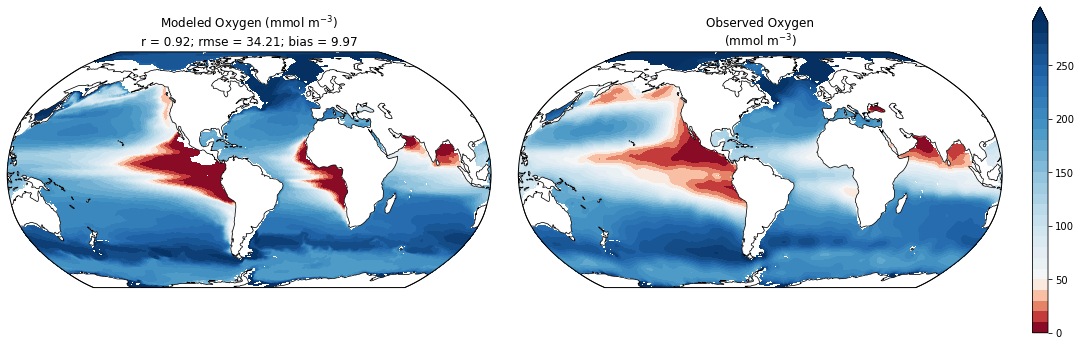

In [21]:
fig=plt.figure(figsize=(20,8))
gs=gridspec.GridSpec(1,2, wspace=0.05, width_ratios=[1,1.25])

ax={};cs={}

cmin = -2; cmax = 0.5; cint = 0.05
levels=np.arange(cmin,cmax,cint)

###########################################################################
# oxygen                                                                     #
###########################################################################
cmin=0; cmax=300; cint=10
levels=np.arange(cmin,cmax,cint)

cmap = ['#67001f','#b2182b','#d6604d','#f4a582',
        '#fddbc7','#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#08519c','#08306b']
i=0
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=300.0))
field=ds_o2.o2
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), norm=MidpointNormalize(midpoint=50.), extend='max', levels=levels, cmap='RdBu')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Modeled Oxygen (mmol m$^{-3}$)\nr = ' + str(np.round(r_o2,2)) + \
                 '; rmse = ' + str(np.round(rmse_o2,2)) + \
                 '; bias = ' + str(np.round(bias_o2,2)), fontsize=12)

i=1
ax[i]=plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=300.0))
field=o2_obs.O2_woa18
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), norm=MidpointNormalize(midpoint=50.), extend='max', levels=levels, cmap='RdBu')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Oxygen\n(mmol m$^{-3}$)', fontsize=12)

cbar=plt.colorbar(cs[i], ticks=[0,50,100,150,200,250,300], shrink=0.75)

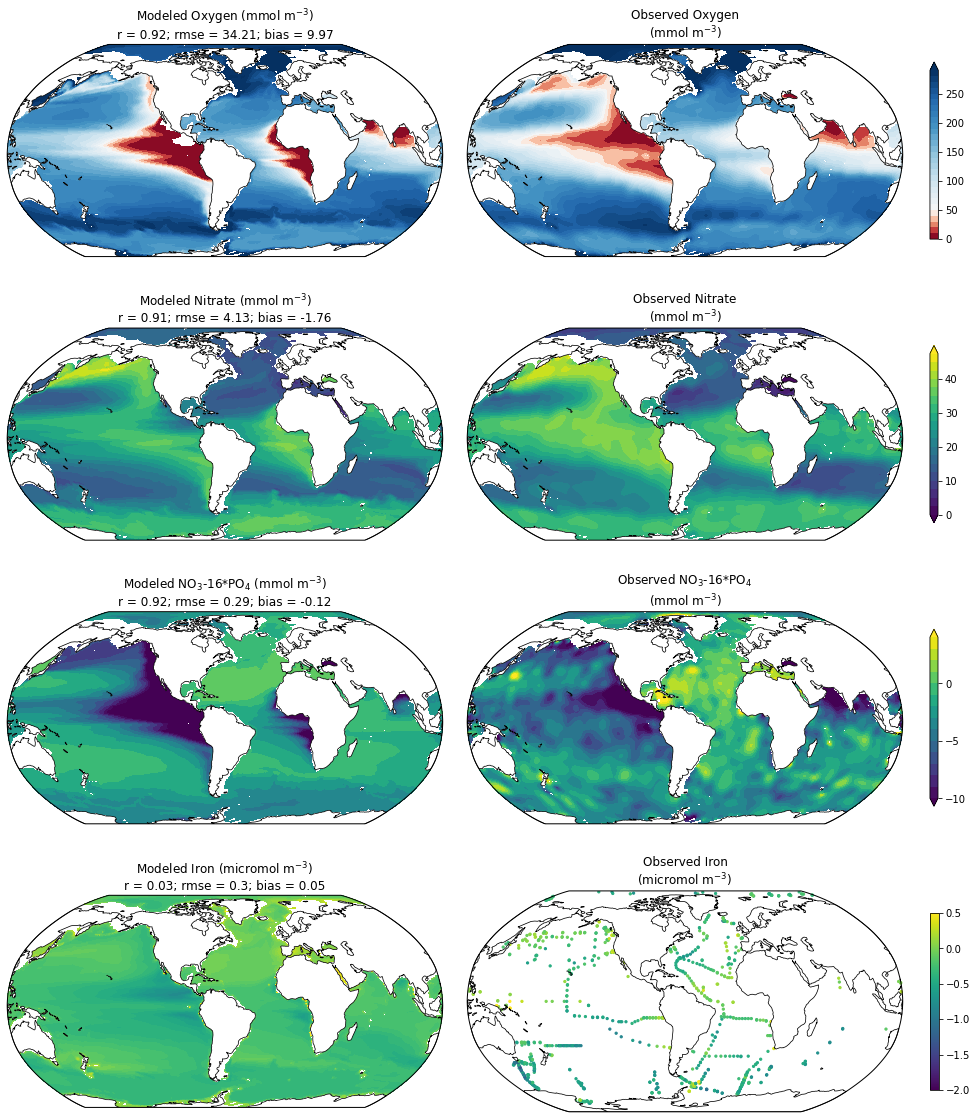

In [22]:
fig=plt.figure(figsize=(18,20))
gs=gridspec.GridSpec(4,2, wspace=0.05, width_ratios=[1,1.25])

ax={};cs={}

fs = 12 #fontsize

###########################################################################
# oxygen                                                                     #
###########################################################################
cmin=0; cmax=300; cint=10
levels=np.arange(cmin,cmax,cint)

i=0
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=300.0))
field=ds_o2.o2
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), norm=MidpointNormalize(midpoint=50.), extend='max', levels=levels, cmap='RdBu')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Modeled Oxygen (mmol m$^{-3}$)\nr = ' + str(np.round(r_o2,2)) + \
                 '; rmse = ' + str(np.round(rmse_o2,2)) + \
                 '; bias = ' + str(np.round(bias_o2,2)), fontsize=fs)

i=1
ax[i]=plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=300.0))
field=o2_obs.O2_woa18
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), norm=MidpointNormalize(midpoint=50.), extend='max', levels=levels, cmap='RdBu')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Oxygen\n(mmol m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[0,50,100,150,200,250,300], shrink=0.75)

###########################################################################
# no3                                                                     #
###########################################################################
cmin=0; cmax=50; cint=2.5
levels=np.arange(cmin,cmax,cint)

i=2
ax[i]=plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=300.0))
field=ds_no3.no3
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Modeled Nitrate (mmol m$^{-3}$)\nr = ' + str(np.round(r_no3,2)) + \
                 '; rmse = ' + str(np.round(rmse_no3,2)) + \
                 '; bias = ' + str(np.round(bias_no3,2)), fontsize=fs)

i=3
ax[i]=plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=300.0))
field=no3_obs.nitrate_woa18
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Nitrate\n(mmol m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[0,10,20,30,40,50], shrink=0.75)

###########################################################################
# N star                                                                  #
###########################################################################
cmin = -10; cmax = 5; cint = 1
levels=np.arange(cmin,cmax,cint)

i=4
ax[i]=plt.subplot(gs[2,0],projection=ccrs.Robinson(central_longitude=300.0))
field=N_star
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Modeled NO$_3$-16*PO$_4$ (mmol m$^{-3}$)\nr = ' + str(np.round(r_po4,2)) + \
                 '; rmse = ' + str(np.round(rmse_po4,2)) + \
                 '; bias = ' + str(np.round(bias_po4,2)), fontsize=fs)

i=5
ax[i]=plt.subplot(gs[2,1],projection=ccrs.Robinson(central_longitude=300.0))
field=N_star_obs
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed NO$_3$-16*PO$_4$\n(mmol m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[-10,-5,0,5], shrink=0.75)

###########################################################################
# Iron                                                                    #
###########################################################################

cmin = -2; cmax = 0.5; cint = 0.05
levels=np.arange(cmin,cmax,cint)

i=6
ax[i]=plt.subplot(gs[3,0],projection=ccrs.Robinson(central_longitude=300.0))
field=np.log10(ds_dfe_clim.dfe.mean(dim='month').values)
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Modeled Iron (micromol m$^{-3}$)\nr = ' + str(np.round(r_dfe,2)) + \
                 '; rmse = ' + str(np.round(rmse_dfe,1)) + \
                 '; bias = ' + str(np.round(bias_dfe,2)), fontsize=fs)

i=7
ax[i]=plt.subplot(gs[3,1],projection=ccrs.Robinson(central_longitude=300.0))
field=np.log10(dfe_obs.fed_obs_500m.mean(dim='time').values)
cs[i]=ax[i].scatter(grid.geolon.values, grid.geolat.values, s=5, c=field, transform=ccrs.PlateCarree(), vmin=cmin, vmax=cmax)
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Iron\n(micromol m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], shrink=0.75)
cbar.ax.set_xticks(ticks=np.arange(-2,0.5,0.5),labels=np.round(10**np.arange(-2,0.5,0.5)))

plt.tight_layout()
fname = 'Fig17_500m_nutrients'+expt
plt.savefig('../plots/'+fname+'.png', dpi=300, bbox_inches='tight')